# Homework: Implement a Mixture of Experts Model

## Overview

In this homework, you'll implement a Mixture of Experts (MoE) model for classifying points generated from two Gaussian distributions.

Please submit your Jupyter Notebook with all the completed tasks and questions answered.

In [1]:
# Import Libraries

import math

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
import numpy as np
import torch
from IPython.display import HTML, display


def set_default(figsize=(10, 10), dpi=100):
    plt.style.use(['dark_background', 'bmh'])
    plt.rc('axes', facecolor='k')
    plt.rc('figure', facecolor='k')
    plt.rc('figure', figsize=figsize, dpi=dpi)


def plot_data(X, y, d=0, auto=False, zoom=1):
    X = X.cpu()
    y = y.cpu()
    plt.scatter(X.numpy()[:, 0], X.numpy()[:, 1], c=y, s=20, cmap=plt.cm.Spectral)
    plt.axis('square')
    plt.axis(np.array((-1.1, 1.1, -1.1, 1.1)) * zoom)
    if auto is True: plt.axis('equal')
    plt.axis('off')

    _m, _c = 0, '.15'
    plt.axvline(0, ymin=_m, color=_c, lw=1, zorder=0)
    plt.axhline(0, xmin=_m, color=_c, lw=1, zorder=0)

def plot_expert_model(X, y, model):
    model.cpu()
    mesh = np.arange(-10,10, 0.01)
    xx, yy = np.meshgrid(mesh, mesh)
    with torch.no_grad():
        data = torch.from_numpy(np.vstack((xx.reshape(-1), yy.reshape(-1))).T).float()
        Z = model(data).detach()
    Z = (Z>0.5).reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.3)
    plot_data(X, y)
def plot_gating_model(X, y, model):
    model.cpu()
    mesh = np.arange(-10,10, 0.01)
    xx, yy = np.meshgrid(mesh, mesh)
    with torch.no_grad():
        data = torch.from_numpy(np.vstack((xx.reshape(-1), yy.reshape(-1))).T).float()
        Z = model(data).detach()
    Z = np.argmax(Z, axis=1).reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.3)
    plot_data(X, y)
set_default()

In [2]:
# Generate the Dataset
def generate_data(n_samples=2000):
  X = torch.zeros(n_samples, 2)
  y = torch.zeros(n_samples, dtype=torch.long)

  # Generate samples from two Gaussian distributions
  X[:n_samples//2] = torch.randn(n_samples//2, 2) + torch.Tensor([3,2])
  X[n_samples//2:] = torch.randn(n_samples//2, 2) + torch.Tensor([-3,2])

  # Labels
  for i in range(X.shape[0]):
    if X[i].norm() > math.sqrt(13):
      y[i] = 1

  X[:, 1] = X[:, 1] - 2

  return X, y

data, labels = generate_data()

Question: Plot the generated dataset. Do you think a linear model would be able to separate the classes well?

Text(0.5, 1.0, 'Distribution of labels over data (red=0, blue=1)')

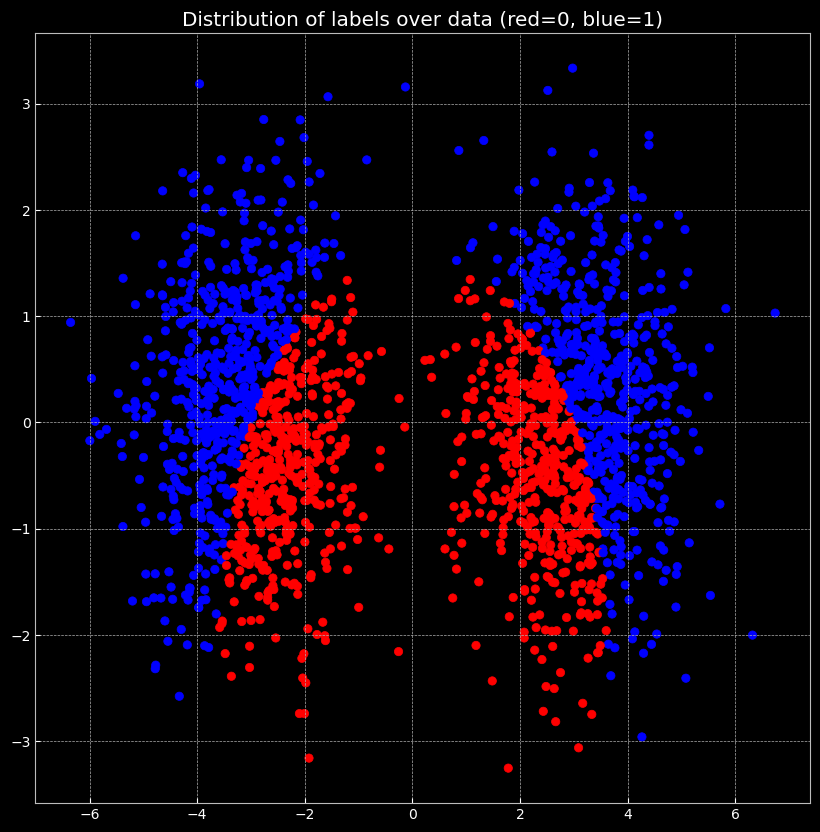

In [3]:
colors = ['red' if label == 0 else 'blue' for label in labels]
plt.scatter(data[:,0], data[:,1], c=colors)
plt.title("Distribution of labels over data (red=0, blue=1)")


- no this data does not seem easily linearly separable

## Expert Model

Task: Implement the Expert model. It should be a simple neural network with one linear layer.



In [4]:
class Expert(nn.Module):
  # TODO: Implement the Expert class
    def __init__(self):
        super(Expert, self).__init__()
        self.linear = nn.Linear(2, 1)
    def forward(self, x):
        return self.linear(x)

## Gating Network

Task: Implement the Gating Network. It should output the probabilities for choosing each expert.

In [5]:
class GatingNetwork(nn.Module):
    def __init__(self, num_experts):
        super(GatingNetwork, self).__init__()
        self.linear = nn.Linear(2, num_experts)
    def forward(self, x):
        return F.softmax(self.linear(x), dim=1)

## Mixture of Experts

Task: Implement the Mixture of Experts model. This model should utilize the Expert and Gating Network models to make a final prediction.

In [6]:
class MixtureOfExperts(nn.Module):
    def __init__(self, num_experts =2 ):
        super(MixtureOfExperts, self).__init__()
        self.experts = nn.ModuleList([Expert() for i in range(num_experts)])
        self.gating_network = GatingNetwork(num_experts)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        g = self.gating_network(x)
        y_hat = torch.zeros(x.shape[0], 1)
        for i in range(len(self.experts)):
            y_hat += g[:, i].view(-1, 1) * self.experts[i](x)
        return self.sigmoid(y_hat)

## Training Loop

Task: Write a training loop to train the Mixture of Experts model. Use binary cross-entropy loss and an Adam optimizer. Also, implement a learning rate scheduler that decays the learning rate.

In [20]:
# Define the model, loss, and optimizer
model = MixtureOfExperts()
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)

# Define the learning rate scheduler ## try a scheduler that starts off slow gets fast and then goes slow again
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5000)

# Convert data and labels to float tensors
data_tensor = data.float()
labels_tensor = labels.view(-1, 1).float()

# Training loop
num_epochs = 10000
for epoch in range(num_epochs):
    # Forward pass

    y_hat = model(data_tensor)
    
    loss = criterion(y_hat, labels_tensor)
    acc = ((y_hat > 0.5) == labels_tensor).sum().float() / len(labels_tensor)
    #acc = (labels== predicted).sum().float() / len(labels)
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Decay the learning rate
    scheduler.step()
    if epoch % 1000 == 0:
        print("epoch: {}, loss: {}, acc: {}".format(epoch, loss.item(), acc))

    


epoch: 0, loss: 0.8334526419639587, acc: 0.5630000233650208
epoch: 1000, loss: 0.1171388104557991, acc: 0.9559999704360962
epoch: 2000, loss: 0.09690534323453903, acc: 0.9649999737739563
epoch: 3000, loss: 0.09128401428461075, acc: 0.9674999713897705
epoch: 4000, loss: 0.08751320838928223, acc: 0.9679999947547913
epoch: 5000, loss: 0.10978515446186066, acc: 0.9490000009536743
epoch: 6000, loss: 0.08583351969718933, acc: 0.9674999713897705
epoch: 7000, loss: 0.08560369163751602, acc: 0.9674999713897705
epoch: 8000, loss: 0.08528506755828857, acc: 0.9674999713897705
epoch: 9000, loss: 0.08487121760845184, acc: 0.9674999713897705


## Decision Boundaries
Task: Plot the decision boundaries of the two experts, the gating network and the final model

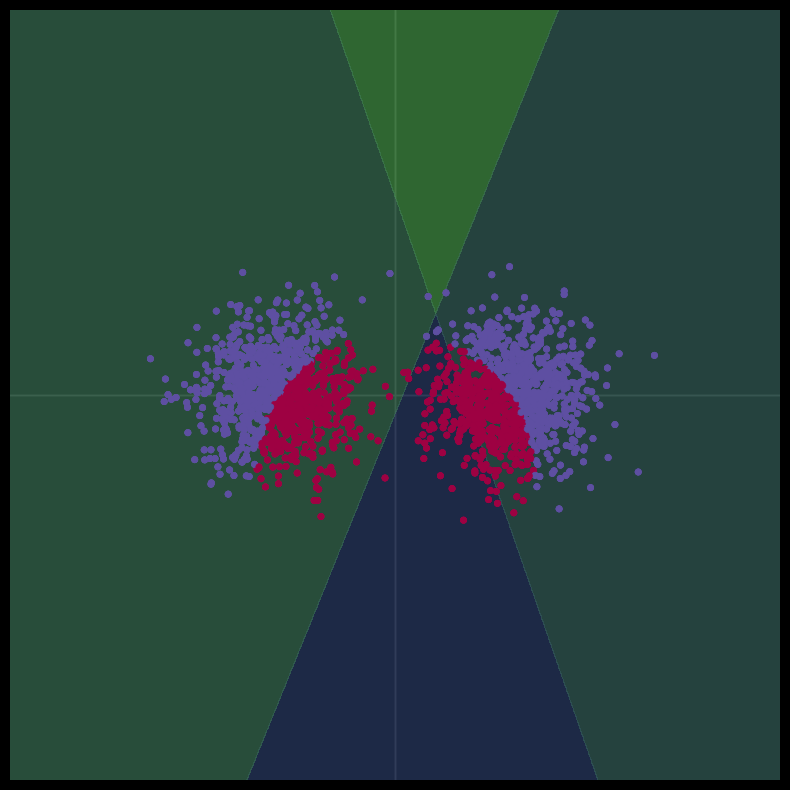

In [15]:
plot_expert_model(data, labels, model.experts[0])

plot_expert_model(data, labels, model.experts[1])


plot_data(data_tensor, labels_tensor)
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.show()

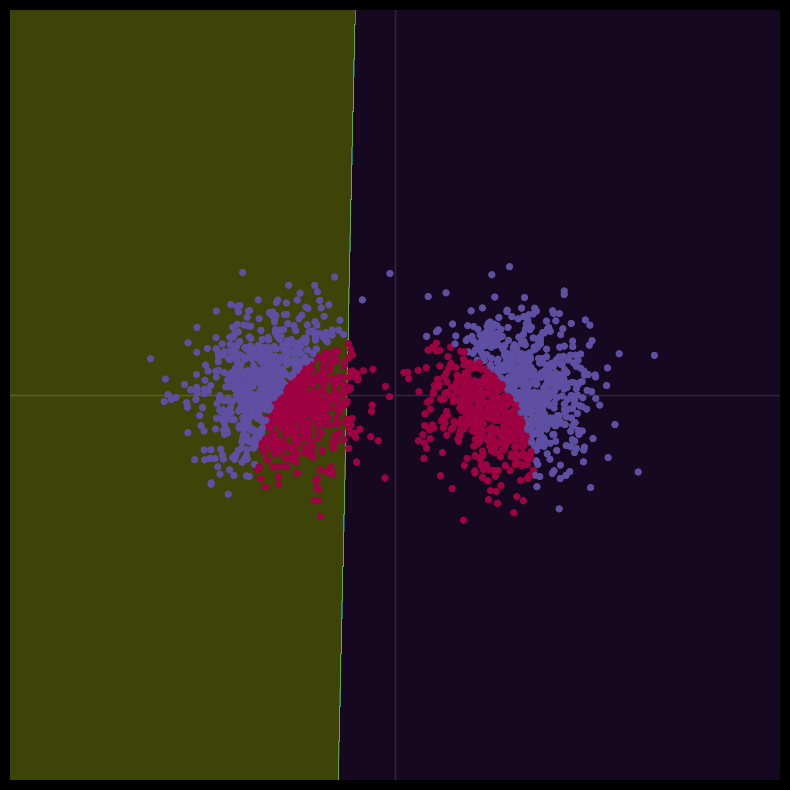

In [16]:

plot_gating_model(data, labels, model.gating_network)
plot_data(data_tensor, labels_tensor)
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.show()

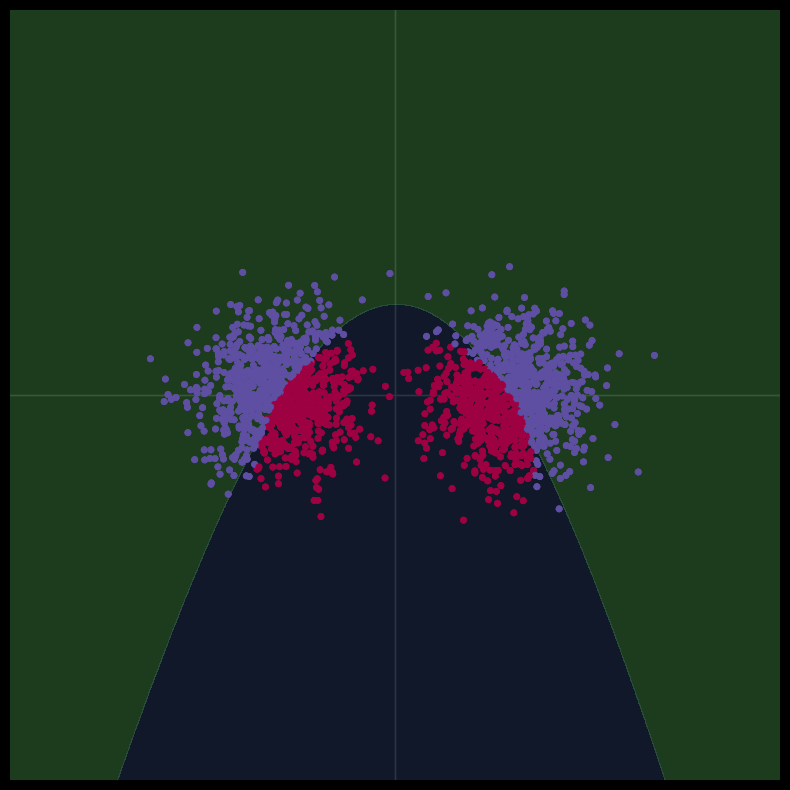

In [17]:

plot_expert_model(data, labels, model)
plot_data(data_tensor, labels_tensor)
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.show()

Question: Analyze the decision boundaries. What differences do you observe between the experts? How does the gating network decide between the two?

- one of the experts tries to learn one side of all points. 
- the gating network learns like the symetric line to the other expert 
- the expert mixes these points linearly.

## Bonus Task (2 points)
Try increasing the number of experts. How does the model complexity and decision boundary change? (You don't need to show your code for the new models, just plot the new decision boundaries and explain what did you find from the plots)



In [26]:
# Define the model, loss, and optimizer
num_experts = 10
model = MixtureOfExperts(num_experts=num_experts)
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)

# Define the learning rate scheduler ## try a scheduler that starts off slow gets fast and then goes slow again
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5000)

# Convert data and labels to float tensors
data_tensor = data.float()
labels_tensor = labels.view(-1, 1).float()

# Training loop
num_epochs = 10000
for epoch in range(num_epochs):
    # Forward pass

    y_hat = model(data_tensor)
    
    loss = criterion(y_hat, labels_tensor)
    acc = ((y_hat > 0.5) == labels_tensor).sum().float() / len(labels_tensor)
    #acc = (labels== predicted).sum().float() / len(labels)
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Decay the learning rate
    scheduler.step()
    if epoch % 1000 == 0:
        print("epoch: {}, loss: {}, acc: {}".format(epoch, loss.item(), acc))

    


epoch: 0, loss: 0.6859884262084961, acc: 0.5590000152587891
epoch: 1000, loss: 0.025420155376195908, acc: 0.9909999966621399
epoch: 2000, loss: 0.01970301754772663, acc: 0.9925000071525574
epoch: 3000, loss: 0.016684560105204582, acc: 0.9929999709129333
epoch: 4000, loss: 0.01504542212933302, acc: 0.9944999814033508
epoch: 5000, loss: 0.013644823804497719, acc: 0.9955000281333923
epoch: 6000, loss: 0.013515026308596134, acc: 0.9955000281333923
epoch: 7000, loss: 0.013311830349266529, acc: 0.9955000281333923
epoch: 8000, loss: 0.013005281798541546, acc: 0.9955000281333923
epoch: 9000, loss: 0.012570410035550594, acc: 0.9955000281333923


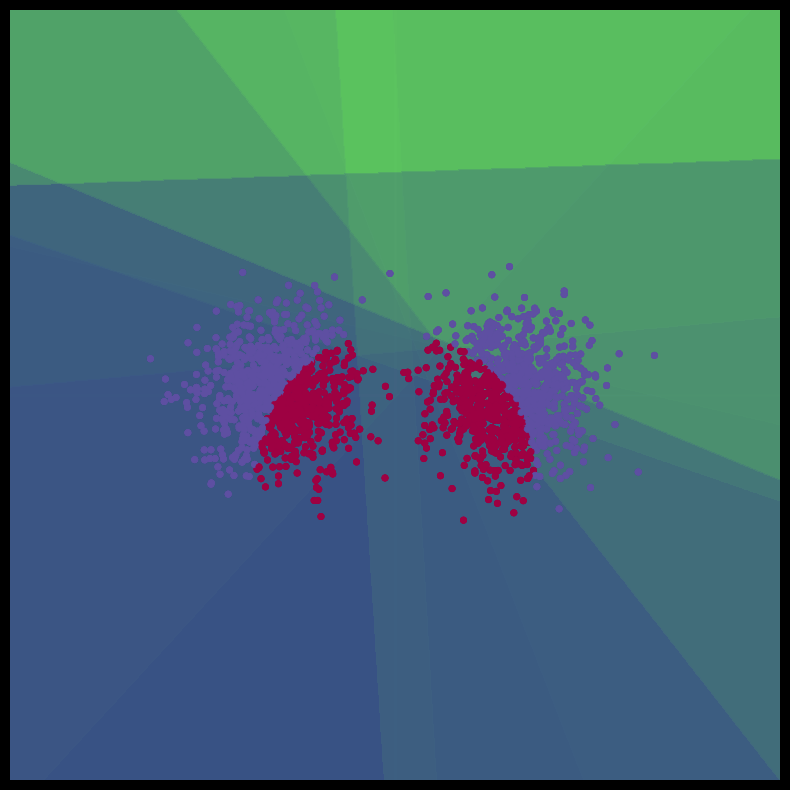

In [27]:
for i in range(num_experts):
    plot_expert_model(data, labels, model.experts[i])
plot_data(data_tensor, labels_tensor)
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.show()

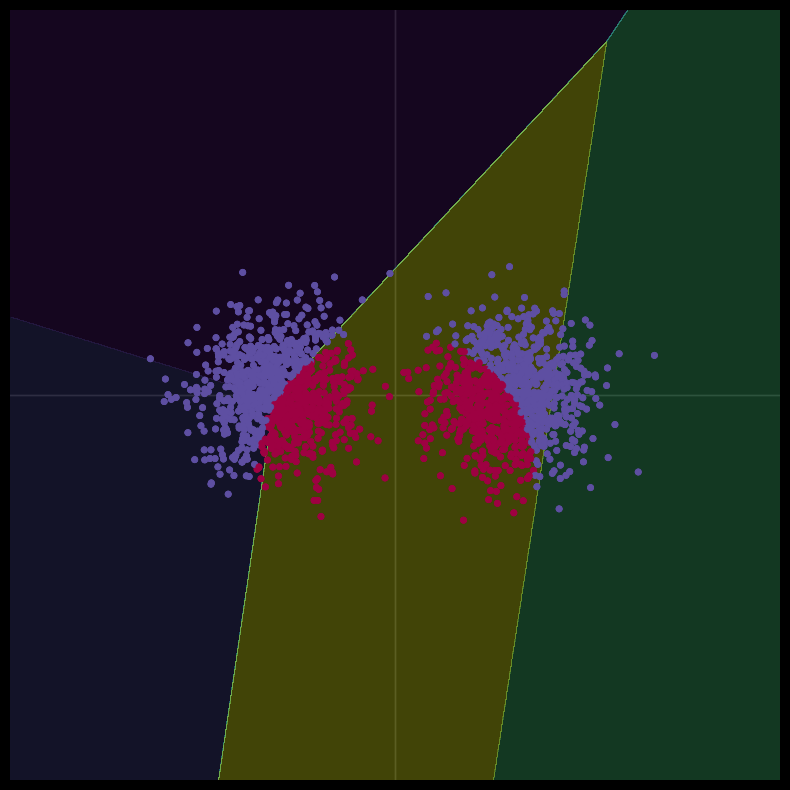

In [28]:

plot_gating_model(data, labels, model.gating_network)
plot_data(data_tensor, labels_tensor)
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.show()

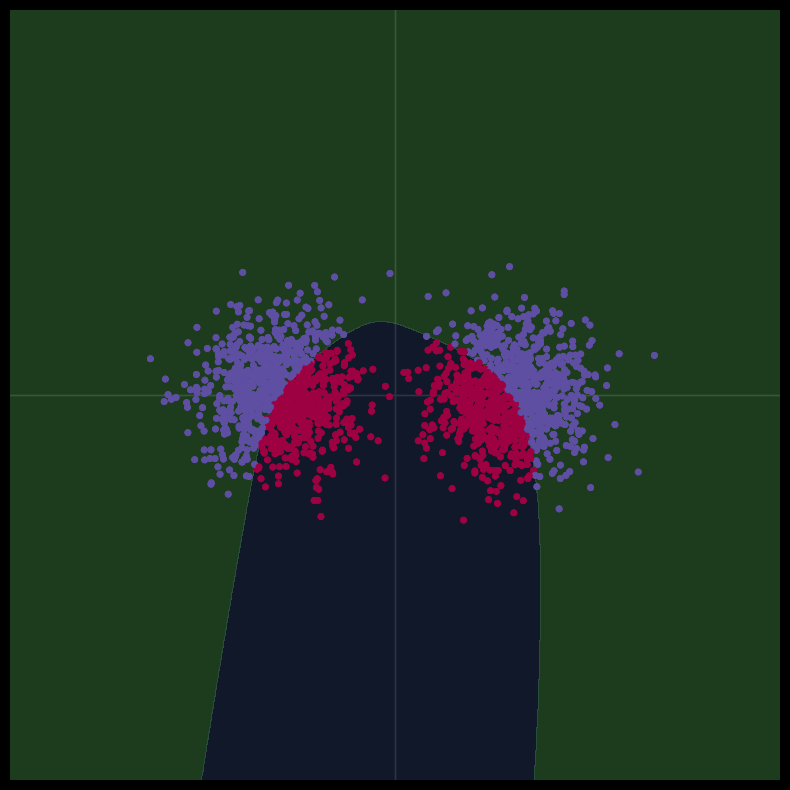

In [29]:

plot_expert_model(data, labels, model)
plot_data(data_tensor, labels_tensor)
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.show()

- more or less what happens is each expert learns a more unique section of the data. 
- and the net result for the overall model is a decsion boundary that is both smoother, and further away from linear 
so in this case it is kind of oblong to round.